# Teapot

dreaming of chihuahua

## Setup

In [403]:
import random
import math
import torch
import torch.nn.functional as F
import PIL
import copy
from tqdm.auto import tqdm
import transformers
from transformers import AutoImageProcessor, ResNetForImageClassification
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline

In [404]:
transformers.logging.set_verbosity_error() # suppress warnings
# load things from huggingface
dataset = load_dataset("huggingface/cats-image")
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

In [405]:
# !wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Black_tea_pot_cropped.jpg/640px-Black_tea_pot_cropped.jpg -O teapot.jpg

## ResNet-50 demo from huggingface
have a look at how the pre-trained ResNet-50 from huggingface works

### classification

In [406]:
image = dataset["test"]["image"][0]
inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

tiger cat


### Look at the processor
The processor does a lot of little things to the picture before feeding it to the model:
- crop
- resize
- rescale
- normalize

And more. The problem here is that normalized images look funky to human

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


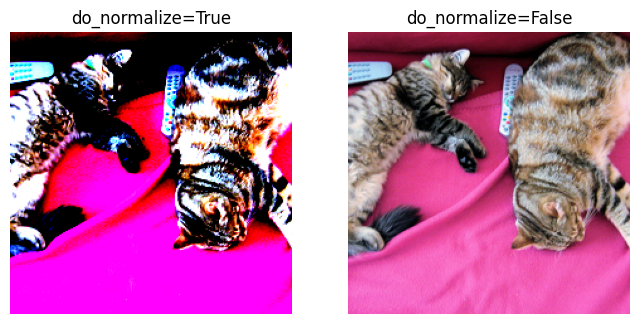

In [407]:
image = dataset["test"]["image"][0]
img_normalized = processor(image, return_tensors="pt")
img_not_normalized = processor(image, return_tensors="pt", do_normalize=False)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].axis('off')
ax[0].imshow(img_normalized['pixel_values'][0].permute(1, 2, 0))
ax[0].set_title("do_normalize=True")
ax[1].axis('off')
ax[1].imshow(img_not_normalized['pixel_values'][0].permute(1, 2, 0))
ax[1].set_title("do_normalize=False")
_ = plt.show()

## Fooling ResNet-50
The goal is to modify a picture just enough for the network to classify it as what we decide, but still have humans recognize it as the original picture.

In [408]:
# Hyperparameters
do_normalize = False # keep images human readable

### Labels
ResNet-50 was trained on a 1000 labels.

The choice of labels totally escape me, it contains:
- ringworm
- unknown species of dogs (kelpie?)
- obscure mushrooms (gyromitra)
- some very long label, e.g. "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum"
- but doesn't include things like the moon...

In [409]:
# take a peek at the labels in the model config
random_labels = list(model.config.id2label.items())
random.shuffle(random_labels)
random_labels[:10]

[(50, 'American alligator, Alligator mississipiensis'),
 (499, 'cleaver, meat cleaver, chopper'),
 (844, 'switch, electric switch, electrical switch'),
 (941, 'acorn squash'),
 (588, 'hamper'),
 (0, 'tench, Tinca tinca'),
 (124, 'crayfish, crawfish, crawdad, crawdaddy'),
 (305, 'dung beetle'),
 (907, 'wine bottle'),
 (968, 'cup')]

### Helpers

In [410]:
@torch.no_grad()
def classify(pic):
    '''Classify the pic and returns (predicted_label_idx, predicted_label, raw_confidence, confidence)'''
    logits = model(pic).logits
    raw_confidence = logits.max(-1)[0].item()
    confidence = logits.softmax(-1).max(-1)[0].item()
    predicted_label_idx = logits.argmax(-1)[0].item()
    predicted_label = model.config.id2label[predicted_label_idx]
    return predicted_label_idx, predicted_label, raw_confidence, confidence

In [411]:
# plot the image and optinal labels in a grid
def plot(*args, n_col=None, figsize=None, axis_off=True):
    '''Plot the images in a grid with optional labels'''
    # prepare the elements to plot as (image, label)
    elems = []
    for el in args:
        if isinstance(el, torch.Tensor):
            if el.dim() == 4: el = el[0] # if picture is a batch, take the first one
            assert el.dim() == 3, f"Wrong image shape {el.shape}"
            if el.shape[0] == 3: el = el.permute(1, 2, 0)
            if el.requires_grad: el = el.detach()
            elems.append([el])
        elif isinstance(el, str): elems[-1].append(el)
        else: raise ValueError(f"Wrong element ({type(el)}) {repr(el)}")
    elems = [(el[0], el[1] if len(el) == 2 else None) for el in elems]

    # plot the images
    n_col = n_col or len(elems)
    n_row = math.ceil(len(elems) / n_col)
    figsize = figsize or (n_col * 4, n_row * 4)
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    for i, (img, label) in enumerate(elems):
        idx = (i,) if n_row == 1 or n_col == 1 else (i // n_col, i % n_col)
        if label: ax[*idx].set_title(label)
        ax[*idx].imshow(img)
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i,) if n_row == 1 or n_col == 1 else (i // n_col, i % n_col)
        if axis_off: ax[*idx].axis('off')
    plt.tight_layout()
    plt.show()

In [412]:
# make a label for the image
def labelize(img, label):
    predicted_label_idx, predicted_label, raw_confidence, confidence = classify(img)
    return f'{label}\n{predicted_label} ({confidence * 100:.2f}%)'

### Modify a picture by hand
Let's toy around with this picture of a teapot and modify it until the network stops to recognize it.

#### original pic

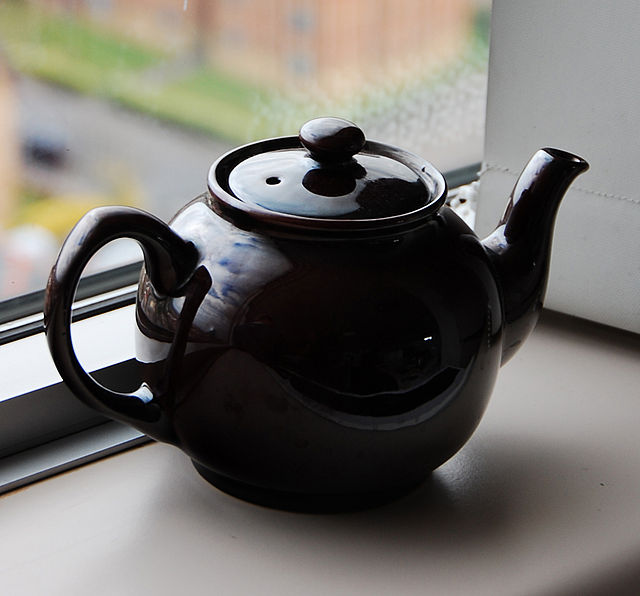

In [413]:
# the teapot (courtesy of wikipedia)
original_teapot = PIL.Image.open("teapot.jpg")
display(original_teapot)

#### Modified

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


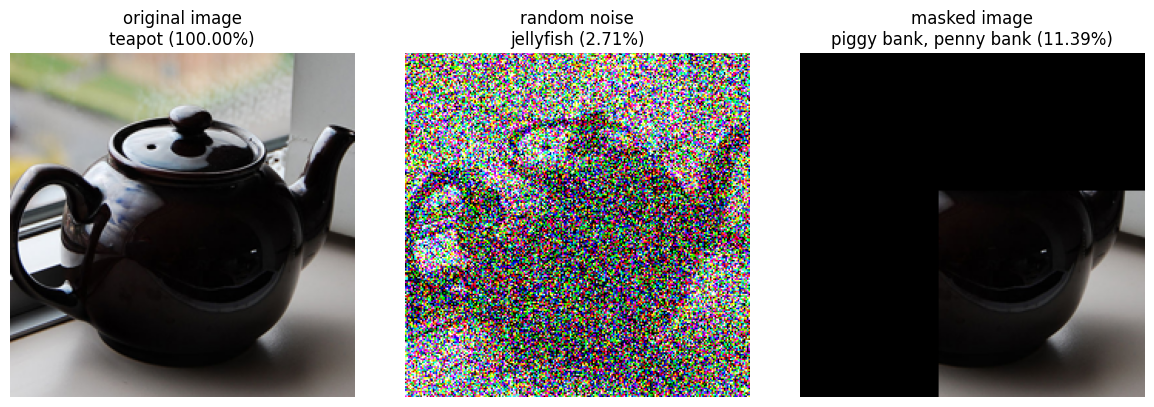

In [414]:
teapot = processor(original_teapot, return_tensors="pt", do_normalize=do_normalize)['pixel_values']
id, _, _, _ = classify(teapot)

# add random noise until it stops being a teapot
noisy_teapot = copy.deepcopy(teapot)
while True:
    noise = torch.randn_like(teapot)
    noisy_teapot += noise
    nid, _, _, _ = classify(noisy_teapot)
    if nid != id: break

# mask sides of the picture until it stops being a teapot
masked_teapot = copy.deepcopy(teapot)
for i in range(0, 224, 10):
    masked_teapot[0, :, :, :i] = 0 # mask a vertical strip on the left
    masked_teapot[0, :, :i, :] = 0 # mask an horizontal strip on the top
    nid, _, _, _ = classify(masked_teapot)
    if nid != id: break

plot(teapot, labelize(teapot, 'original image'),
     noisy_teapot, labelize(noisy_teapot, 'random noise'),
     masked_teapot, labelize(masked_teapot, 'masked image'))

### Mofigy using gradient
Compute the gradient of the teapot with the desired label (e.g. "bubble"). And update the image with the generated gradient as noise, until it matches with the desired category.

To get the gradient I add a tensor of the same size as the trainingset filled with 0, and look at the gradient of this layer. By construction it will have the same gradient as the pixels in the image would.

In [415]:
# Hyperparameters
target_idx = 971 # bubble
epochs = 100
log_every = 10
learning_rate = 0.01

  0%|          | 0/100 [00:00<?, ?it/s]

   0 loss=tensor(16.5275, grad_fn=<NllLossBackward0>)
  10 loss=tensor(7.0498, grad_fn=<NllLossBackward0>)
  20 loss=tensor(5.4607, grad_fn=<NllLossBackward0>)
Predicted bubble in 27 epochs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


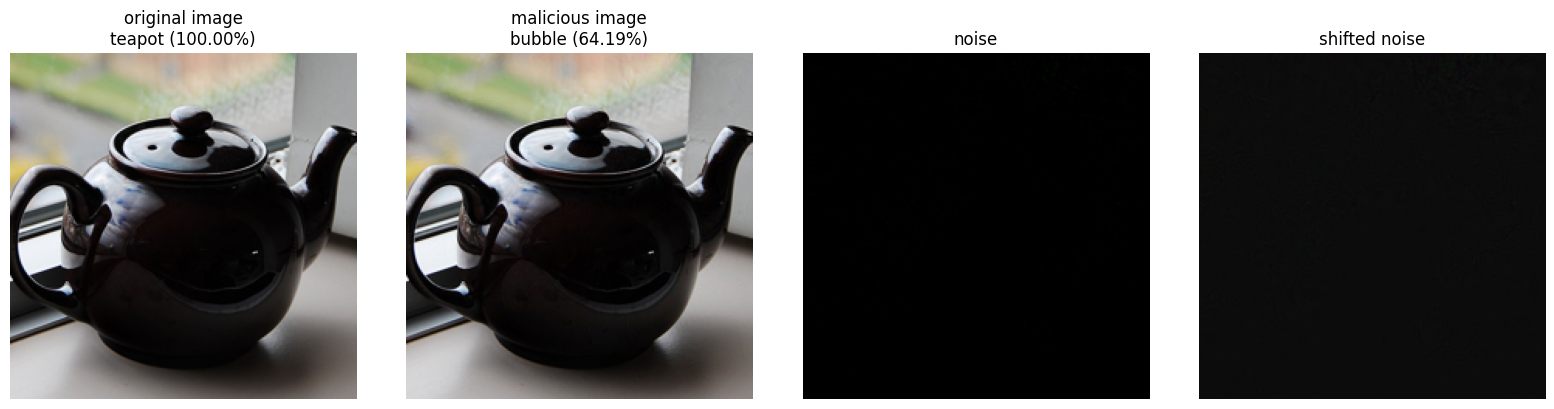

In [416]:
def morph(teapot, target_idx=target_idx):
  # some trick to get a gradient
  gradient_noise = torch.zeros_like(teapot, requires_grad=True)
  malicious_teapot = copy.deepcopy(teapot) + gradient_noise

  for epoch in tqdm(range(epochs)):
    # forward pass
    logits = model(malicious_teapot).logits
    predicted_idx = logits.argmax(-1).item()
    # shortcircuit as soon as we match the target
    if predicted_idx == target_idx:
      print(f'Predicted {model.config.id2label[predicted_idx]} in {epoch} epochs')
      break

    gradient_noise.grad = None
    loss = F.cross_entropy(logits, torch.tensor([target_idx]))
    loss.backward()
    # update image with noise
    new_noise = gradient_noise.grad * learning_rate
    malicious_teapot -= new_noise
    # logging
    if epoch % log_every == 0:
      print(f"{epoch: 4} {loss=}")
  return malicious_teapot

malicious_teapot = morph(teapot)
noise = malicious_teapot - teapot
shifted_noise = noise - noise.min()
plot(teapot, labelize(teapot, 'original image'),
     malicious_teapot, labelize(malicious_teapot, 'malicious image'),
     noise, 'noise',
     shifted_noise, 'shifted noise')

## Dreaming of Chihuahua
Now let's keep on morphing the image until it becomes more and more the target

In [437]:
# Hyperparameters
target_idx = 151 # chihuahu
# target_idx = 84  # peacock
# target_idx = 947 # mushroom
epochs = 1000
log_every = 50
learning_rate = 0.02
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [418]:
m = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

  0%|          | 0/1000 [00:00<?, ?it/s]

   0 loss=tensor(17.8920, device='cuda:0', grad_fn=<NllLossBackward0>)
  50 loss=tensor(8.2132e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 100 loss=tensor(2.2769e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 150 loss=tensor(1.4424e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 200 loss=tensor(1.0371e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 250 loss=tensor(7.7486e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 300 loss=tensor(6.1989e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 350 loss=tensor(5.2452e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 400 loss=tensor(4.4107e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 450 loss=tensor(3.6955e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 500 loss=tensor(3.2186e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 550 loss=tensor(2.7418e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 600 loss=tensor(2.5034e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 650 loss=tensor(2.2650e-06, device='cuda

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


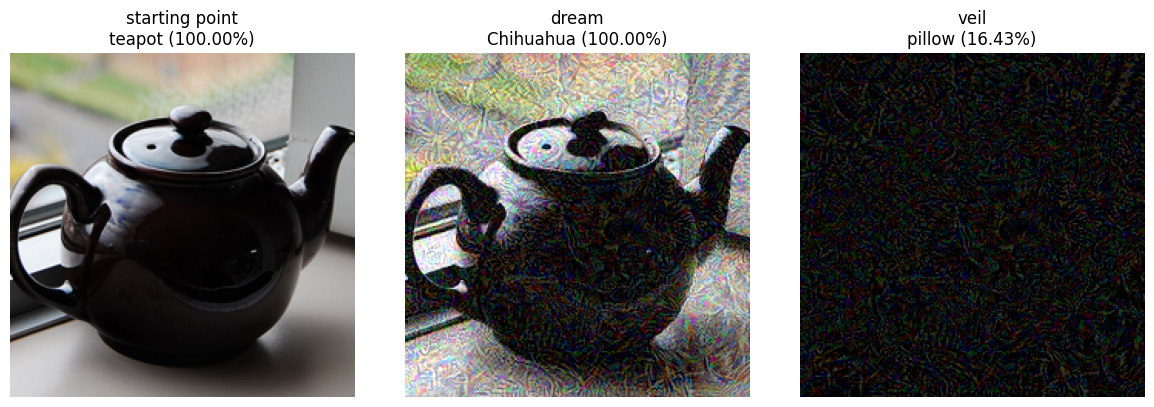

In [438]:
def deepdream(start, veil=None, model=m, target_idx=target_idx):
  # start = copy.deepcopy(start)
  # if veil is None: veil = torch.zeros_like(start, requires_grad=True)
  if veil is None: veil = torch.zeros_like(start)
  target = torch.tensor([target_idx])

  # move to device
  m = model.to(device)
  start = start.to(device)
  veil = veil.to(device).requires_grad_()
  target = torch.tensor([target_idx]).to(device)

  # create optimizer
  # optimizer = torch.optim.AdamW([veil], lr=learning_rate)
  optimizer = torch.optim.Adam([veil], lr=learning_rate)

  for epoch in tqdm(range(epochs)):
    # some trick to get a gradient
    dream = start + veil
    # forward pass
    logits = m(dream).logits
    loss = F.cross_entropy(logits, target)
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # logging
    if epoch % log_every == 0:
      print(f"{epoch: 4} {loss=}")
  return start + veil, veil

dream, veil = deepdream(teapot)
# dream, veil = deepdream(torch.ones_like(teapot) * 0.5)
# dream, veil = deepdream(torch.normal(mean=120, std=10.0, size=teapot.shape))

dream, veil = dream.to('cpu'), veil.to('cpu')
plot(teapot, labelize(teapot, 'starting point'),
     dream, labelize(dream, 'dream'),
     veil, labelize(veil, 'veil'))

In [475]:
m.resnet.encoder.stages[3].layers[0].layer[1].

SyntaxError: invalid syntax (3036408134.py, line 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

   0 loss=tensor(8.3788, device='cuda:0', grad_fn=<NllLossBackward0>)
  50 loss=tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
 100 loss=tensor(5.6265e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 150 loss=tensor(3.7193e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 200 loss=tensor(2.7656e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 250 loss=tensor(2.1696e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 300 loss=tensor(1.8000e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 350 loss=tensor(1.4901e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 400 loss=tensor(1.2636e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 450 loss=tensor(1.0967e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
 500 loss=tensor(9.6559e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 550 loss=tensor(8.8214e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 600 loss=tensor(7.7486e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
 650 loss=tensor(7.1525e-06, device='cuda:0', 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


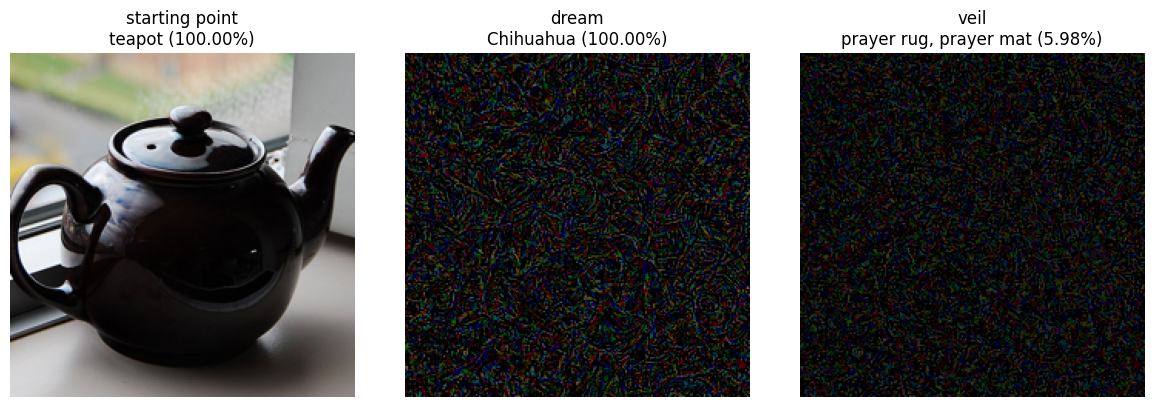

In [440]:
# dream on - aerosmith
dream, veil = deepdream(veil)
dream, veil = dream.to('cpu'), veil.to('cpu')
plot(teapot, labelize(teapot, 'starting point'),
     dream, labelize(dream, 'dream'),
     veil, labelize(veil, 'veil'))